In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/DL_mansi_assignment2/
!pwd

Mounted at /content/drive
/content/drive/MyDrive/DL_mansi_assignment2
/content/drive/MyDrive/DL_mansi_assignment2


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing, model_selection as ms
import sys

In [ ]:
df_dataset = pd.read_csv('winequality-white.csv', sep=';')

display(df_dataset.head())
display(df_dataset.info())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


None

In [ ]:
 
X_train, X_test, Y_train, Y_test = ms.train_test_split(df_dataset.drop(['quality'], axis=1), df_dataset['quality'], test_size = 0.30)


print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

print(X_train.head())
print('\n',Y_train.head())

(3428, 11) (3428,)
(1470, 11) (1470,)
      fixed acidity  volatile acidity  citric acid  ...    pH  sulphates  alcohol
4067            6.9              0.38         0.28  ...  3.16       0.72     10.6
4481            6.4              0.32         0.26  ...  3.14       0.50      9.6
1037            7.1              0.47         0.24  ...  3.21       0.56      9.7
209             6.1              0.40         0.31  ...  3.22       0.77      9.5
543             6.7              0.24         0.41  ...  3.22       0.62      9.9

[5 rows x 11 columns]

 4067    5
4481    5
1037    5
209     6
543     6
Name: quality, dtype: int64


In [ ]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate, act_fn):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.input_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate
        
        self.act_fn = act_fn
        self.tanh_fn = lambda x: (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
        self.relu_fn = lambda x: np.maximum(0,x)
    
    
    def tanh_derivative(self, x):
        tanh_der_output = 1 - self.tanh_fn(x)**2
        return tanh_der_output

    def relu_derivative(self, z):
        z[z<=0] = 0
        z[z>0] = 1
        return z
    
    def train(self, inputs_list, targets_list):
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T

        # print(inputs.shape)
        # print(targets.shape)
        
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)  
        if act_fn == 'tanh':    
            hidden_outputs = self.tanh_fn(hidden_inputs)
        elif act_fn == 'relu':
            hidden_outputs = self.relu_fn(hidden_inputs)
        else:
            print("wrong activation")
            return None
        
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        final_outputs = final_inputs
        
        output_errors = (targets - final_outputs) 
        
        hidden_errors = np.dot(self.weights_hidden_to_output.T, output_errors) 
        if act_fn == 'tanh': 
            hidden_grad = self.tanh_derivative(hidden_inputs)
        elif act_fn == 'relu':
            hidden_grad = self.relu_derivative(hidden_inputs)
        else:
            print("wrong activation")
            return None
        
        hidden_adj = self.lr * np.dot(output_errors ,hidden_outputs.T)
        input_adj =  self.lr * np.dot(hidden_errors * hidden_grad, inputs.T)
        
        self.weights_hidden_to_output += hidden_adj
        self.weights_input_to_hidden += input_adj
 
        
    def run(self, inputs_list):
        inputs = np.array(inputs_list, ndmin=2).T
        
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)
        if self.act_fn == 'tanh':
            hidden_outputs = self.tanh_fn(hidden_inputs)
        elif self.act_fn == 'relu':
            hidden_outputs = self.relu_fn(hidden_inputs)
        else:
            print("wrong activation")
            return None
        
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        final_outputs = final_inputs
        
        return final_outputs

def MSE(y, Y):
    return np.mean((y-Y)**2)

In [ ]:
def nn_trainer(epochs, lr, hidden_nodes, output_nodes, act_fn):
    N_i = X_train.shape[1]
    network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate, act_fn)

    losses = {'train':[], 'validation':[]}
    for e in range(epochs):
        batch = np.random.choice(X_train.index, size=128)
        for record, target in zip(X_train.loc[batch].values, Y_train.loc[batch]):
            network.train(record, target)
        # network.train(X_train.loc[batch].values, Y_train.loc[batch].values)
        
        train_loss = MSE(network.run(X_train), Y_train.values)
        val_loss = MSE(network.run(X_test), Y_test.values)
        sys.stdout.write("\rProgress: " + str(100 * e/float(epochs))[:4] + "% ... Training loss: " + str(train_loss)[:5] + " ... Validation loss: " + str(val_loss)[:5])
        
        losses['train'].append(train_loss)
        losses['validation'].append(val_loss)
    
    return losses

Progress: 99.9% ... Training loss: 0.643 ... Validation loss: 0.640
25 Hidden nodes with Tanh activation


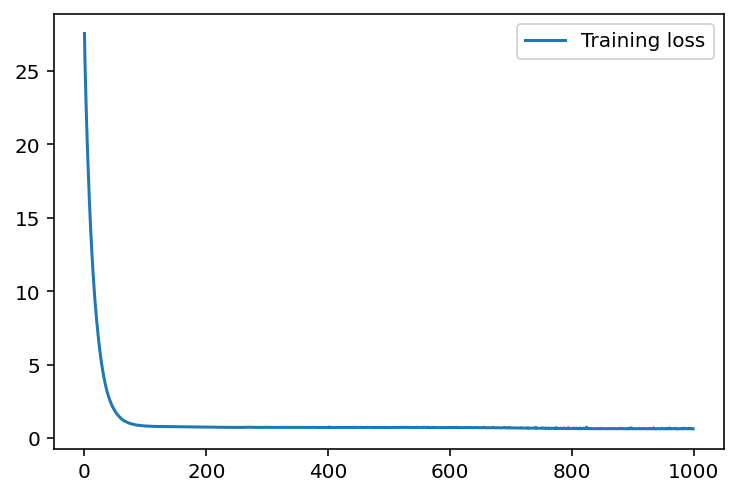

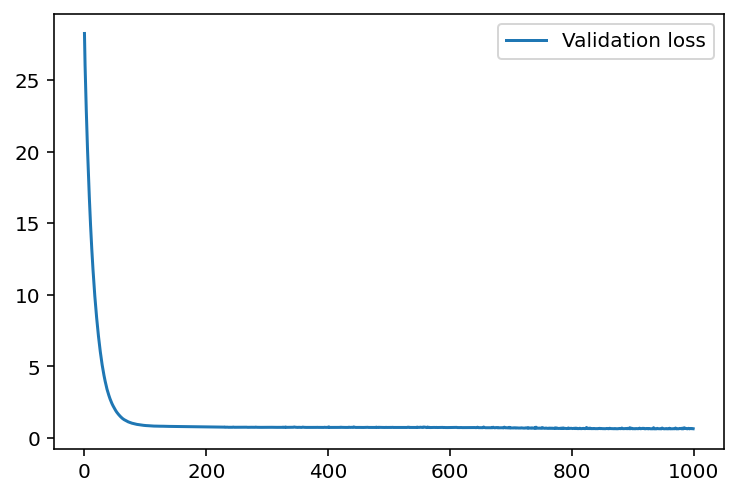

In [ ]:

epochs = 1000
lr = 0.05
hidden_nodes = 25
output_nodes = 1
act_fn = 'tanh'

losses = nn_trainer(epochs, lr, hidden_nodes, output_nodes, act_fn)

print("\n25 Hidden nodes with Tanh activation")

plt.plot(losses['train'], label='Training loss')
plt.legend()
plt.show()

plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.show()

Progress: 99.9% ... Training loss: 0.667 ... Validation loss: 0.651
50 Hidden nodes with Tanh activation


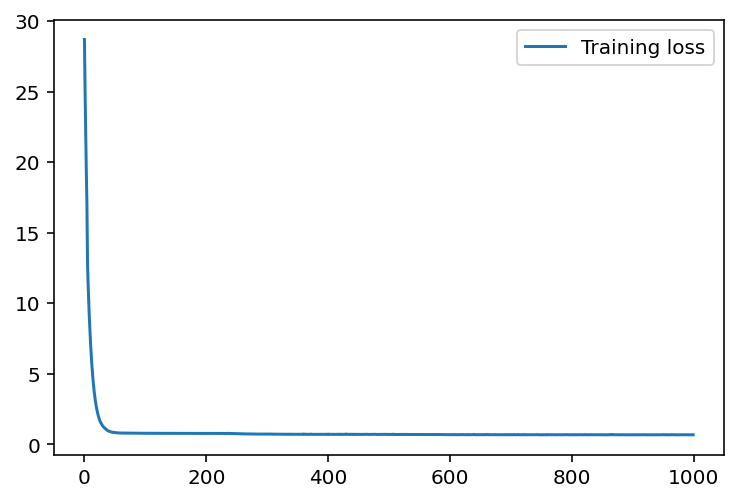

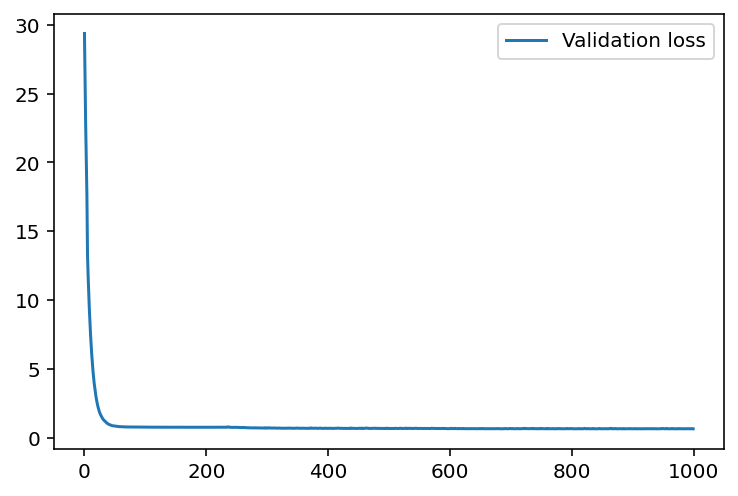

In [ ]:

epochs = 1000
lr = 0.05
hidden_nodes = 50
output_nodes = 1
act_fn = 'tanh'
losses = nn_trainer(epochs, lr, hidden_nodes, output_nodes, act_fn)

print("\n50 Hidden nodes with Tanh activation")

plt.plot(losses['train'], label='Training loss')
plt.legend()
plt.show()

plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.show()

Progress: 99.9% ... Training loss: 0.729 ... Validation loss: 0.716
75 Hidden nodes with Tanh activation


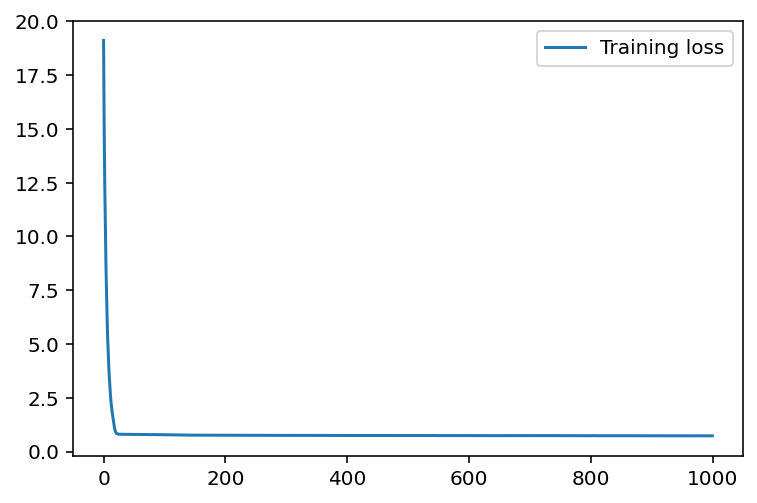

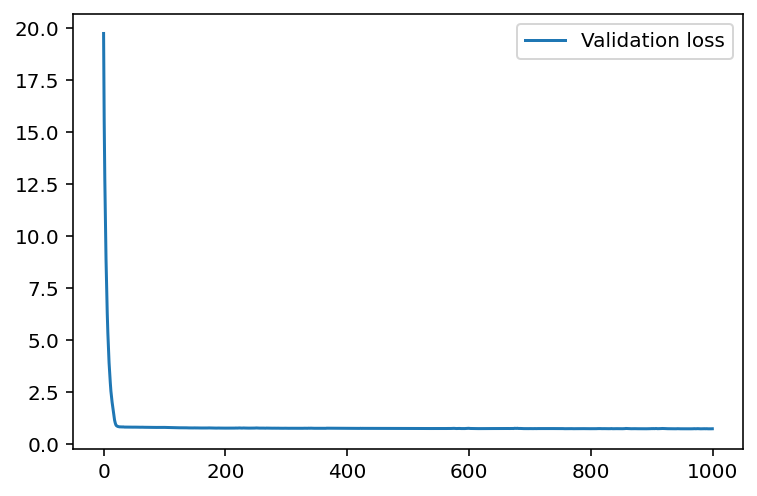

In [ ]:
epochs = 1000
lr = 0.05
hidden_nodes = 75
output_nodes = 1
act_fn = 'tanh'
losses = nn_trainer(epochs, lr, hidden_nodes, output_nodes, act_fn)

print("\n75 Hidden nodes with Tanh activation")

plt.plot(losses['train'], label='Training loss')
plt.legend()
plt.show()

plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.show()

Progress: 99.9% ... Training loss: 0.721 ... Validation loss: 0.689
25 Hidden nodes with Relu activation


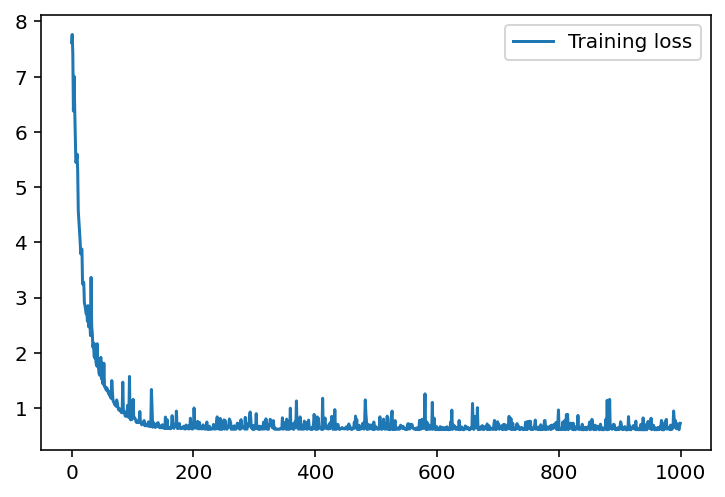

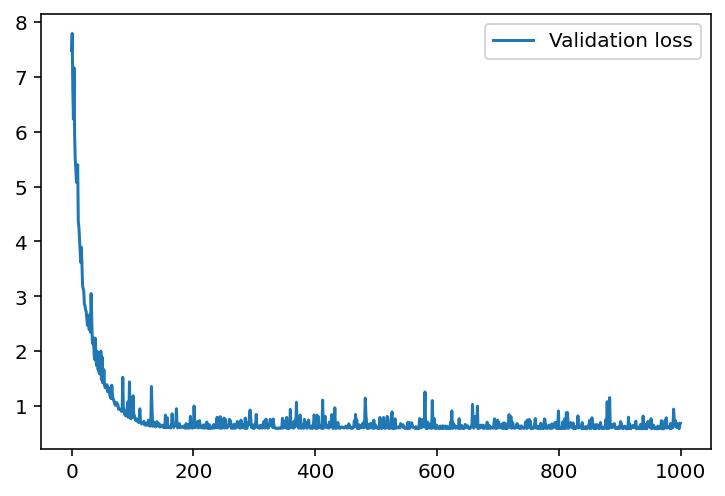

In [ ]:
epochs = 1000
lr = 0.0001
hidden_nodes = 25
output_nodes = 1
act_fn = 'relu'
losses = nn_trainer(epochs, lr, hidden_nodes, output_nodes, act_fn)

print("\n25 Hidden nodes with Relu activation")

plt.plot(losses['train'], label='Training loss')
plt.legend()
plt.show()

plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.show()

Progress: 99.9% ... Training loss: 0.600 ... Validation loss: 0.594
50 Hidden nodes with Relu activation


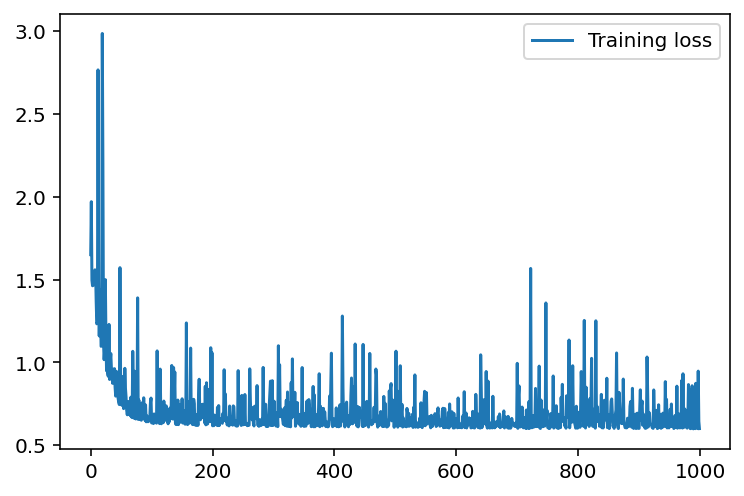

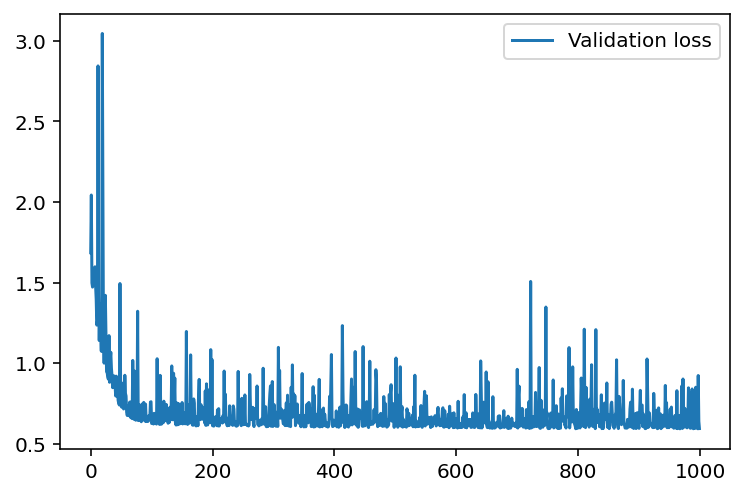

In [ ]:
epochs = 1000
lr = 0.0001
hidden_nodes = 50
output_nodes = 1
act_fn = 'relu'
losses = nn_trainer(epochs, lr, hidden_nodes, output_nodes, act_fn)

print("\n50 Hidden nodes with Relu activation")

plt.plot(losses['train'], label='Training loss')
plt.legend()
plt.show()

plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.show()

Progress: 99.9% ... Training loss: 0.799 ... Validation loss: 0.775
75 Hidden nodes with Relu activation


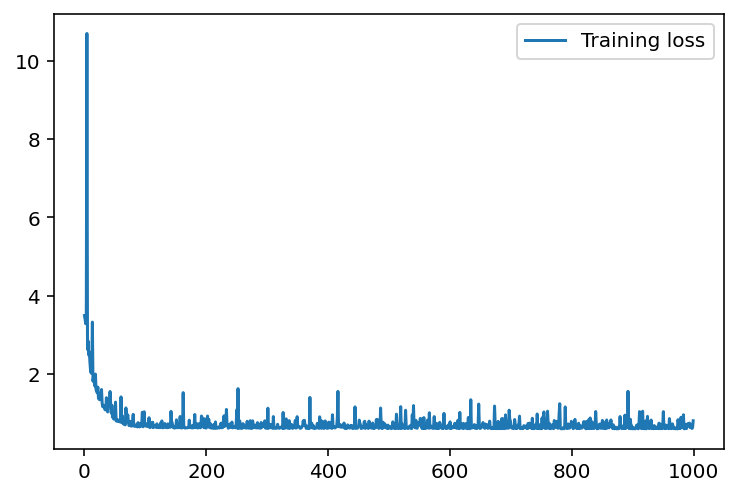

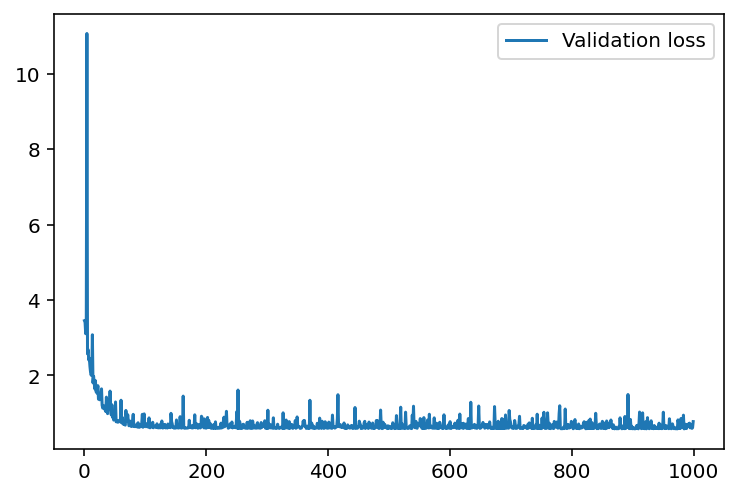

In [ ]:
epochs = 1000
lr = 0.0001
hidden_nodes = 75
output_nodes = 1
act_fn = 'relu'
losses = nn_trainer(epochs, lr, hidden_nodes, output_nodes, act_fn)

print("\n75 Hidden nodes with Relu activation")

plt.plot(losses['train'], label='Training loss')
plt.legend()
plt.show()

plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.show()